In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import hdbscan
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 15})

In [2]:

path = '../data/processed/pca_inputs/MQT_pip.csv'
features = ['std_Log10_n0', 'std_Log10_lambda', 'std_Fs', 'std_Rho', 'std_D0', 'std_Nt', 'std_Sr', 'std_Ed']

df_all = pd.read_csv(path)
df_all.dropna(inplace=True)
df_all = df_all[df_all['Ed'] <= 0.4]
scaled_data = df_all.loc[:, features].values
print(scaled_data)

[[-1.42508708 -0.79392727 -0.93472795 ... -0.49957064 -0.38530344
  -0.9069005 ]
 [-1.4599843  -0.90867856 -0.90268026 ... -0.50001281 -0.38445946
  -0.85583015]
 [-0.90244267 -0.61539049 -0.8392431  ... -0.47941426 -0.38305282
  -0.81625063]
 ...
 [ 0.5708632  -0.1367555  -0.44362668 ... -0.08405597 -0.32400216
  -0.1395685 ]
 [ 0.578684   -0.0026136  -0.47742682 ... -0.09274976 -0.37357208
  -0.28639576]
 [ 0.61833012  0.05213634 -0.56738646 ... -0.07145687 -0.38212444
  -0.21362051]]


In [3]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
reduced = pca.transform(scaled_data)

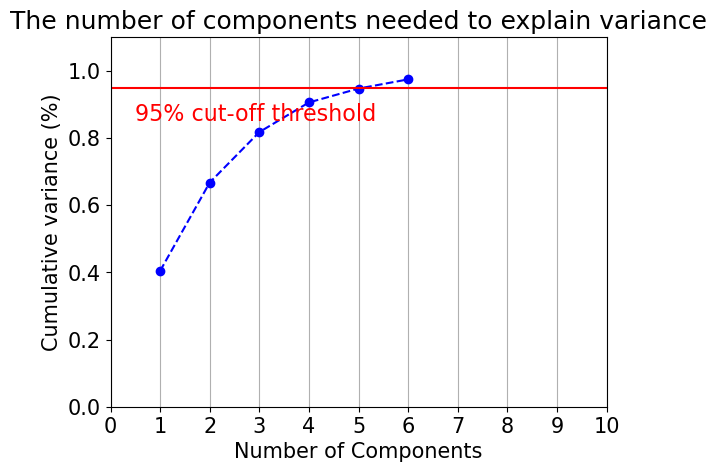

In [4]:
fig, ax = plt.subplots()
xi = np.arange(1, 7, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [5]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['eof1', 'eof2', 'eof3'])

df_all = df_all.reset_index(drop=True)
principalDf = principalDf.reset_index(drop=True)
df_combo = pd.concat([df_all, principalDf], axis=1)
print(pca.explained_variance_ratio_)
print(df_combo)



[0.40408822 0.26306494 0.15013627]
                   time        D0         Nt        Fs       Sr      Ed  \
0       2015-01-31 2:25  1.132814    720.427  0.032079  0.00040  0.0172   
1       2015-01-31 2:30  1.281362    697.520  0.036792  0.00100  0.0252   
2       2015-01-31 2:35  1.190393   1764.648  0.046121  0.00200  0.0314   
3       2015-01-31 2:40  1.296959   2757.418  0.061816  0.00620  0.0386   
4       2015-01-31 2:45  1.076994   1267.181  0.032342  0.00100  0.0286   
...                 ...       ...        ...       ...      ...     ...   
95077  2022-11-16 23:15  1.241243  21848.593  0.103993  0.14544  0.1498   
95078  2022-11-16 23:20  1.177725  24338.703  0.095635  0.10484  0.1528   
95079  2022-11-16 23:25  1.199251  22246.571  0.104299  0.04398  0.1374   
95080  2022-11-16 23:30  1.172974  21796.181  0.099329  0.00874  0.1144   
95081  2022-11-16 23:35  1.006514  22899.280  0.086099  0.00266  0.1258   

            Rho  Log10_n0  Log10_lambda  std_Log10_n0  std_Log10

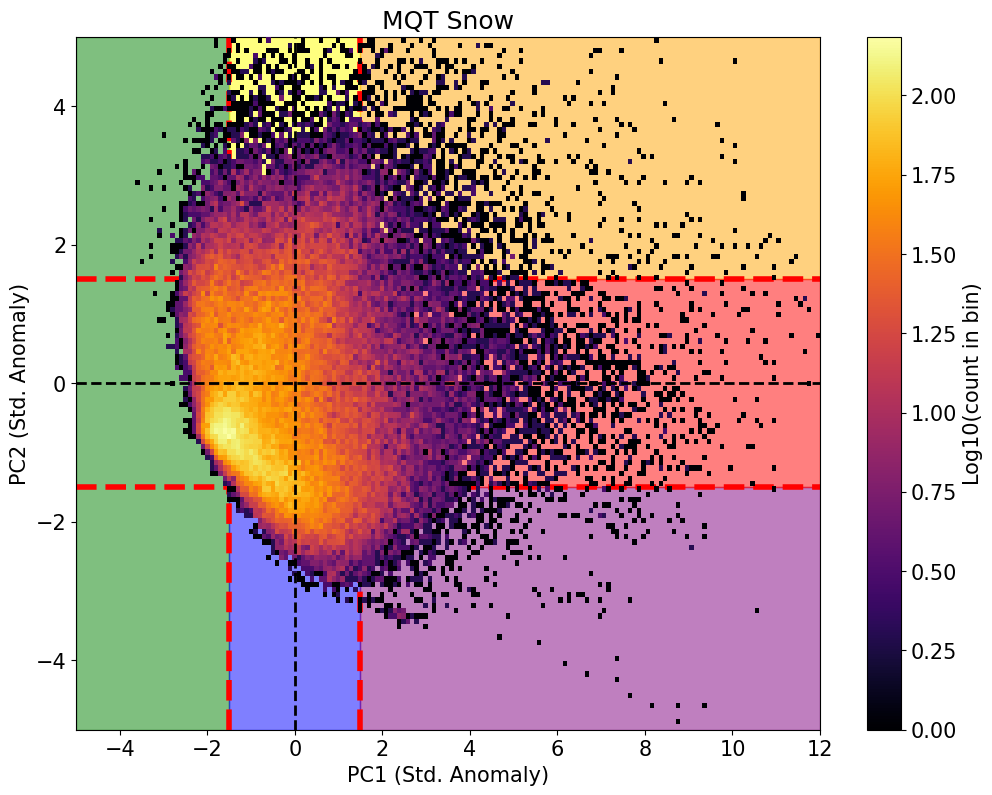

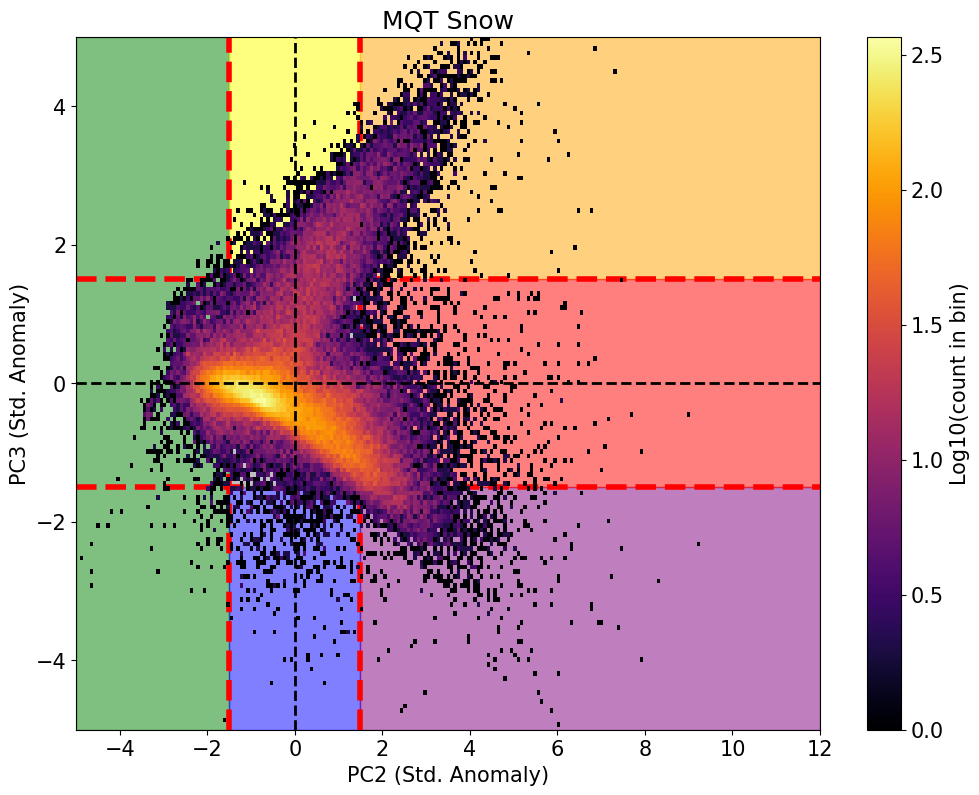

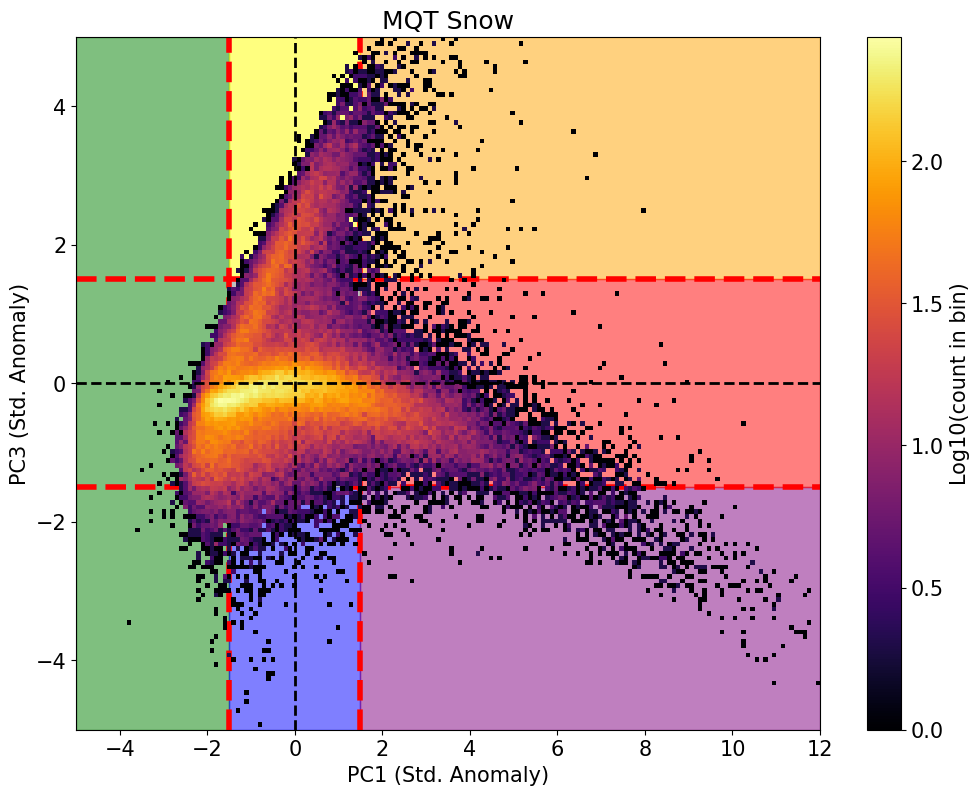

In [6]:

sigma = 1.5

def make_pca_plot(pc_a, pc_b, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.set_facecolor('white')

    plt.title('MQT Snow')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.axvline(-sigma, linewidth=4, color='red', linestyle='--')
    plt.axvline(sigma, linewidth=4, color='red', linestyle='--')
    plt.axhline(-sigma, linewidth=4, color='red', linestyle='--')
    plt.axhline(sigma, linewidth=4, color='red', linestyle='--')
    plt.axhline(0, linewidth=2, color='black', linestyle='--', zorder=1001)
    plt.axvline(0, linewidth=2, color='black', linestyle='--', zorder=1001)

    plt.fill_between([-5, -sigma], -5, 5, color='green', alpha=0.5)
    plt.fill_between([-sigma, sigma], -5, -sigma, color='blue', alpha=0.5)
    plt.fill_between([-sigma, sigma], 5, sigma, color='yellow', alpha=0.5)
    plt.fill_between([sigma, 12], -5, -sigma, color='purple', alpha=0.5)
    plt.fill_between([sigma, 12], sigma, 5, color='orange', alpha=0.5)
    plt.fill_between([sigma, 12], -sigma, sigma, color='red', alpha=0.5)
    plt.fill_between([-sigma, sigma], -sigma, sigma, color='gray', alpha=0.5)
    plt.xlim((-5, 12))
    plt.ylim((-5, 5))

    counts, xedges, yedges = np.histogram2d(pc_a, pc_b, bins=200)
    counts = np.where(counts<1, np.nan, counts)

    counts = np.log10(counts)
    pcm = ax.pcolormesh(xedges, yedges, counts.T, cmap='inferno', rasterized=True, zorder=1000)

    cbar = plt.colorbar(pcm, ax=ax, label='Log10(count in bin)')
    cbar.ax.minorticks_off()  # turn off minor ticks on the colorbar

    plt.show()

make_pca_plot(principalDf.eof1, principalDf.eof2, 'PC1 (Std. Anomaly)', 'PC2 (Std. Anomaly)')
make_pca_plot(principalDf.eof2, principalDf.eof3, 'PC2 (Std. Anomaly)', 'PC3 (Std. Anomaly)')
make_pca_plot(principalDf.eof1, principalDf.eof3, 'PC1 (Std. Anomaly)', 'PC3 (Std. Anomaly)')


In [7]:
#TODO: Group points based on First EOF groupings above

# define ranges for eof1 and eof2
ranges = {
    1: [[-np.inf, -sigma], [-np.inf, np.inf]],
    2: [[-sigma, sigma], [-np.inf, -sigma]],
    3: [[-sigma, sigma], [sigma, np.inf]],
    4: [[sigma, np.inf], [-np.inf, -sigma]],
    5: [[sigma, np.inf], [-sigma, sigma]],
    6: [[sigma, np.inf], [sigma, np.inf]]
}

# define function to assign group based on eof1 and eof2 values
def assign_group(row):
    for group, (range1, range2) in ranges.items():
        if range1[0] <= row['eof1'] <= range1[1] and range2[0] <= row['eof2'] <= range2[1]:
            return group
    # if not in any range, return 7
    return 7

# apply function to each row in dataframe
df_combo['group'] = df_combo.apply(assign_group, axis=1)

print(df_combo)


                   time        D0         Nt        Fs       Sr      Ed  \
0       2015-01-31 2:25  1.132814    720.427  0.032079  0.00040  0.0172   
1       2015-01-31 2:30  1.281362    697.520  0.036792  0.00100  0.0252   
2       2015-01-31 2:35  1.190393   1764.648  0.046121  0.00200  0.0314   
3       2015-01-31 2:40  1.296959   2757.418  0.061816  0.00620  0.0386   
4       2015-01-31 2:45  1.076994   1267.181  0.032342  0.00100  0.0286   
...                 ...       ...        ...       ...      ...     ...   
95077  2022-11-16 23:15  1.241243  21848.593  0.103993  0.14544  0.1498   
95078  2022-11-16 23:20  1.177725  24338.703  0.095635  0.10484  0.1528   
95079  2022-11-16 23:25  1.199251  22246.571  0.104299  0.04398  0.1374   
95080  2022-11-16 23:30  1.172974  21796.181  0.099329  0.00874  0.1144   
95081  2022-11-16 23:35  1.006514  22899.280  0.086099  0.00266  0.1258   

            Rho  Log10_n0  Log10_lambda  std_Log10_n0  ...    std_Ed  \
0      0.002838  1.340745  

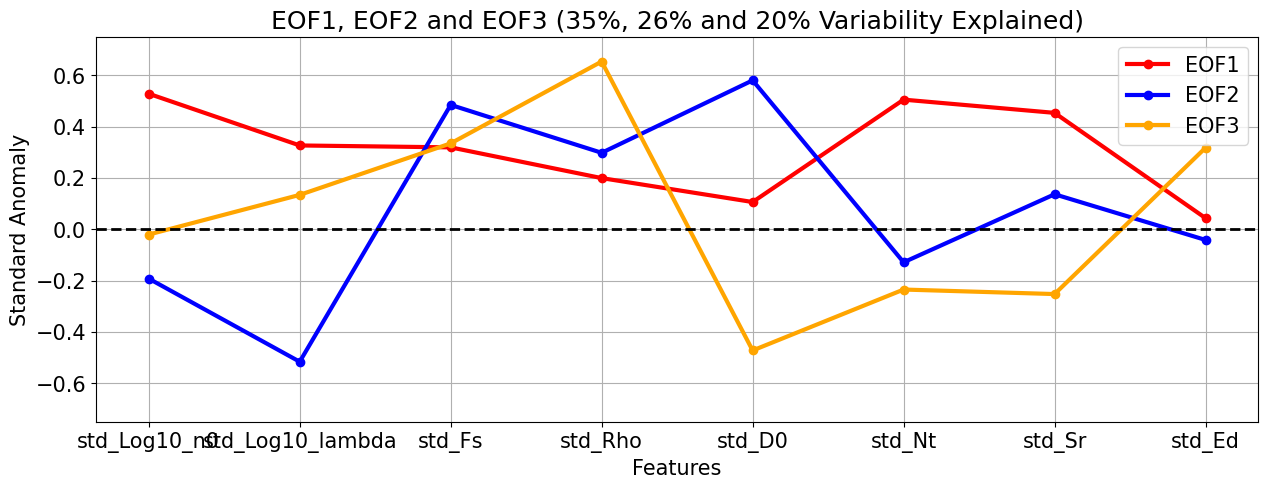

In [8]:
loadings = pd.DataFrame(pca.components_.T, columns=['EOF1', 'EOF2', 'EOF3'], index=['std_Log10_n0', 'std_Log10_lambda', 'std_Fs', 'std_Rho', 'std_D0', 'std_Nt', 'std_Sr', 'std_Ed'])

fig, ax = plt.subplots(figsize=(15,5))

# Generate line plots
ax.plot(loadings['EOF1'], marker='o', color='red', linewidth=3, label='EOF1')
ax.plot(loadings['EOF2'], marker='o', color='blue', linewidth=3, label='EOF2')
ax.plot(loadings['EOF3'], marker='o', color='orange', linewidth=3, label='EOF3')

ax.set_title('EOF1, EOF2 and EOF3 (35%, 26% and 20% Variability Explained)')
ax.set_ylabel('Standard Anomaly')
ax.set_xlabel('Features')
ax.grid(True)
ax.set_ylim((-0.75, 0.75))
ax.axhline(0, linewidth=2, linestyle='--', color='black')
ax.legend()

plt.show()

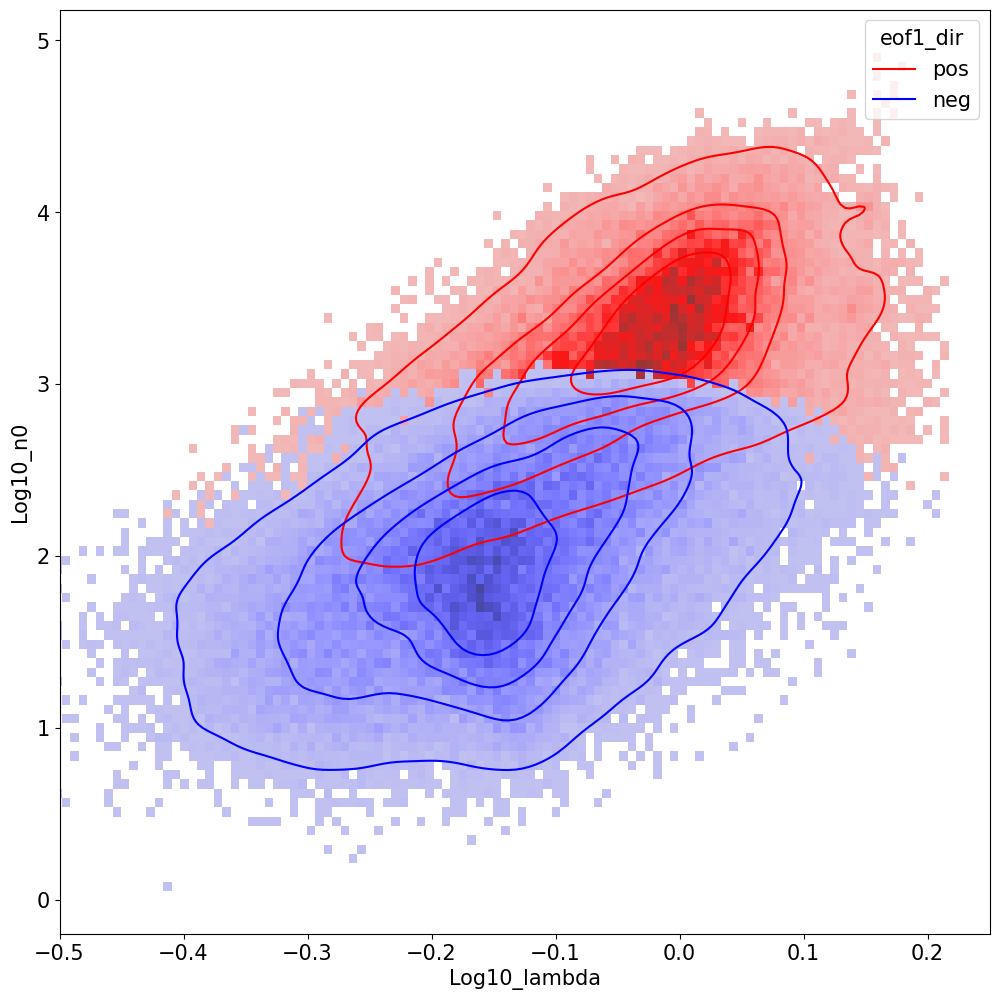

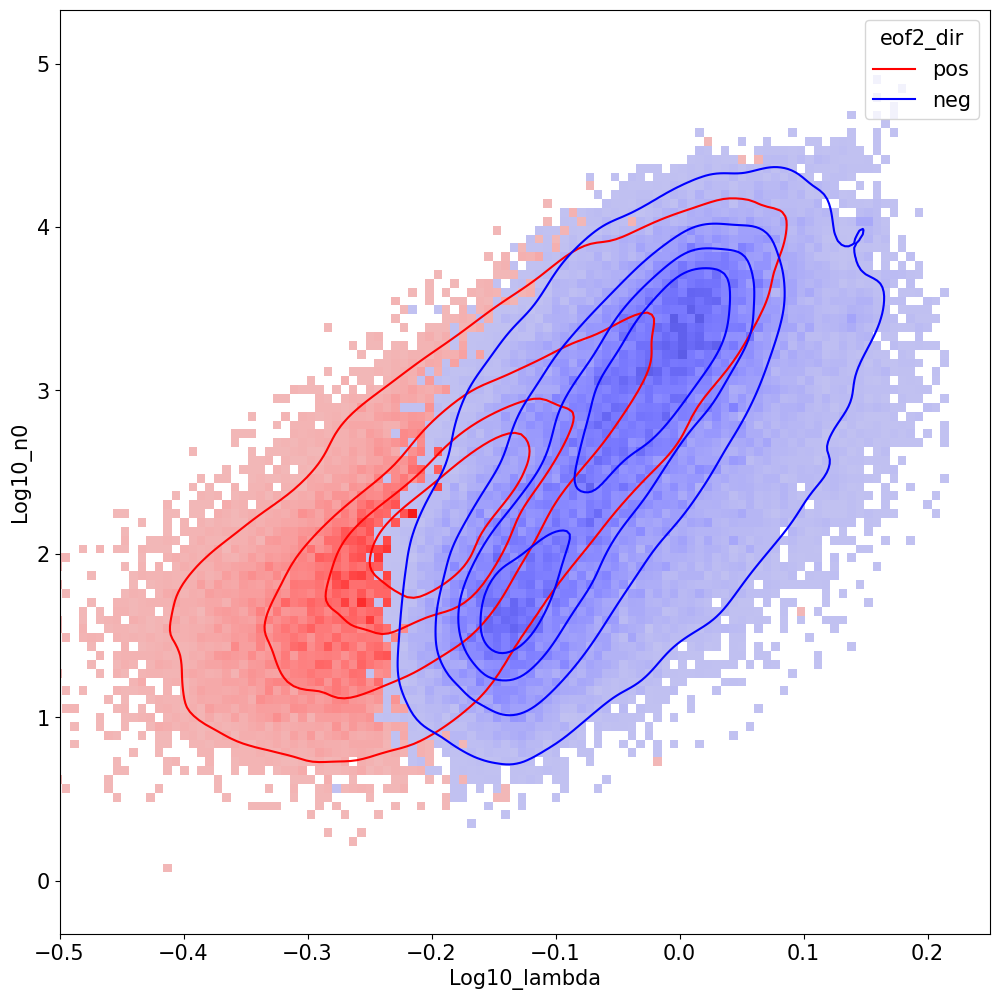

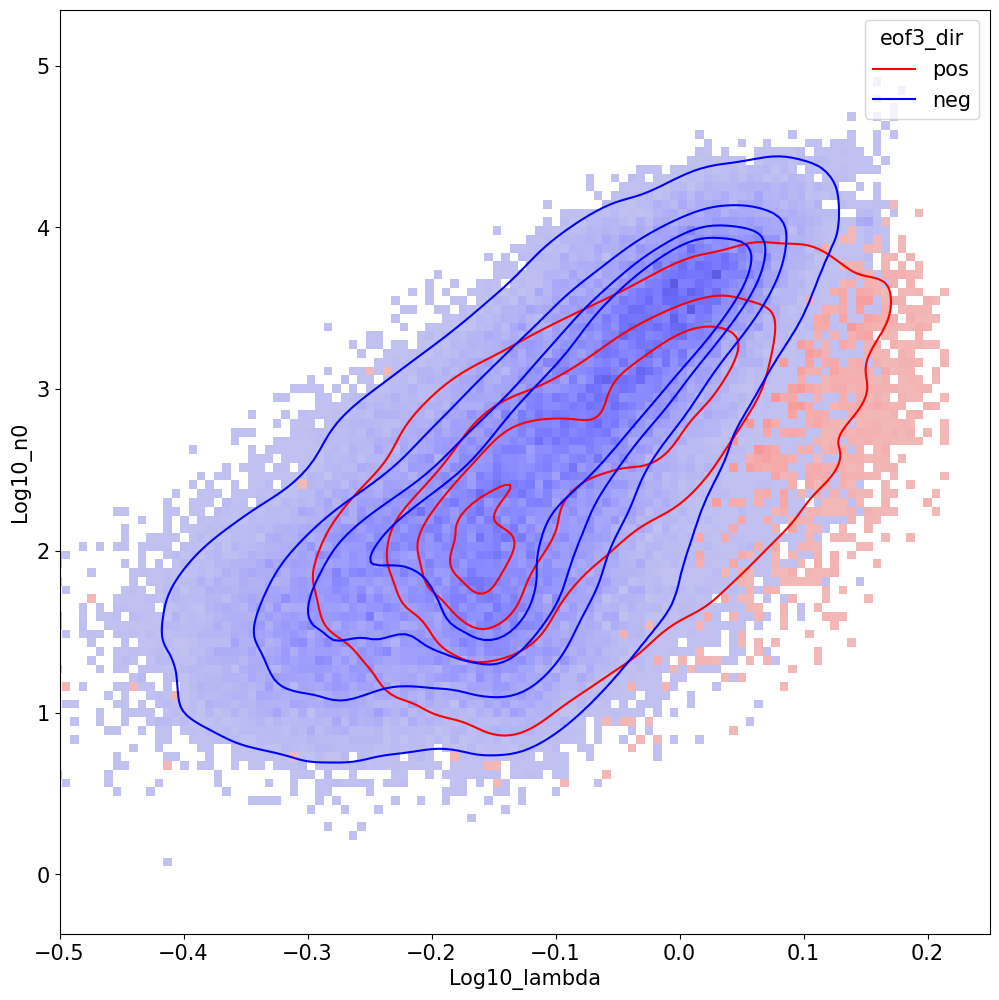

In [9]:

df_combo['eof1_dir'] = df_combo['eof1'].apply(lambda x: 'pos' if x > 0 else 'neg')
df_combo['eof2_dir'] = df_combo['eof2'].apply(lambda x: 'pos' if x > 0 else 'neg')
df_combo['eof3_dir'] = df_combo['eof3'].apply(lambda x: 'pos' if x > 0 else 'neg')


fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof1_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
sns.kdeplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof1_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
plt.show()

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof2_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
sns.kdeplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof2_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
plt.show()

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof3_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
sns.kdeplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="eof3_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
plt.show()



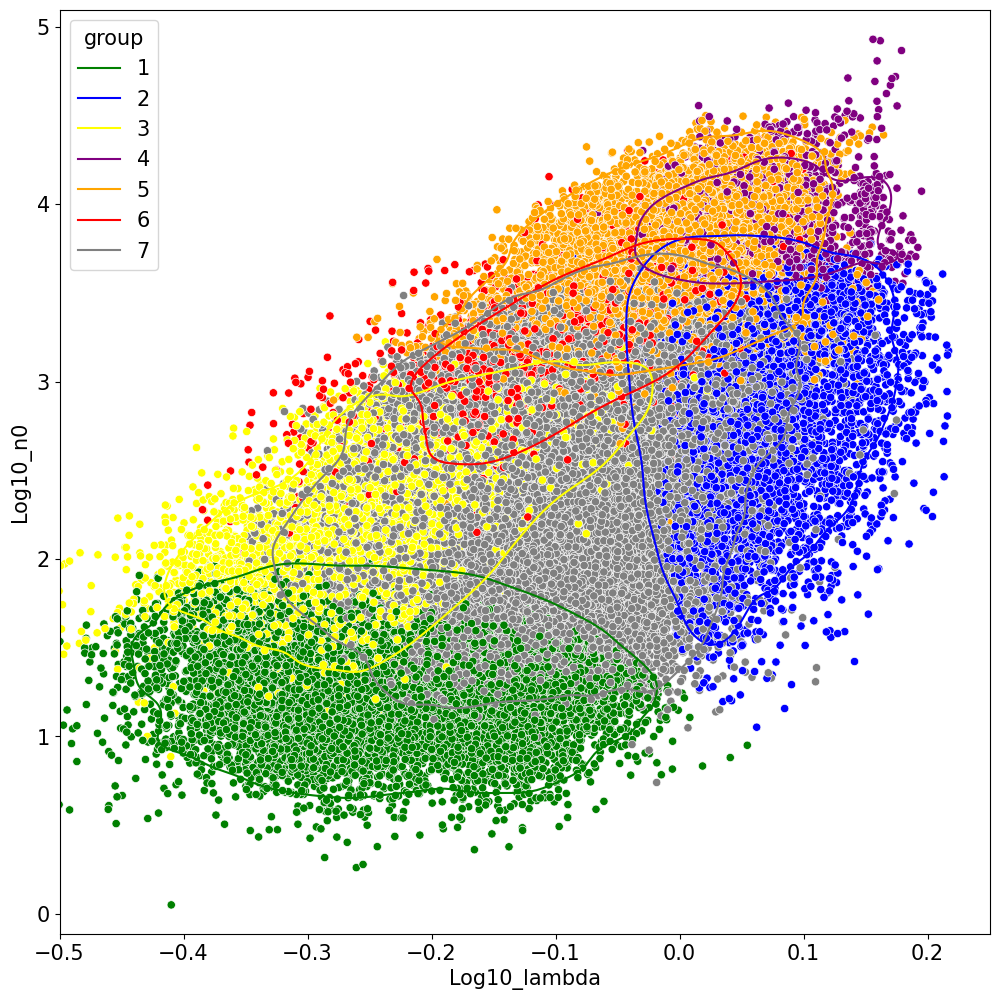

In [10]:

color_dict = {1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple', 5: 'orange', 6: 'red', 7: 'gray'}


fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
# sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="group")
sns.scatterplot(data=df_combo, x="Log10_lambda", y="Log10_n0",  hue_order=[1, 2, 3, 4, 5, 6, 7], hue="group", palette=color_dict)
sns.kdeplot(data=df_combo, x="Log10_lambda", y="Log10_n0", levels=2, hue="group",  hue_order=[1, 2, 3, 4, 5, 6, 7], palette=color_dict)

plt.show()

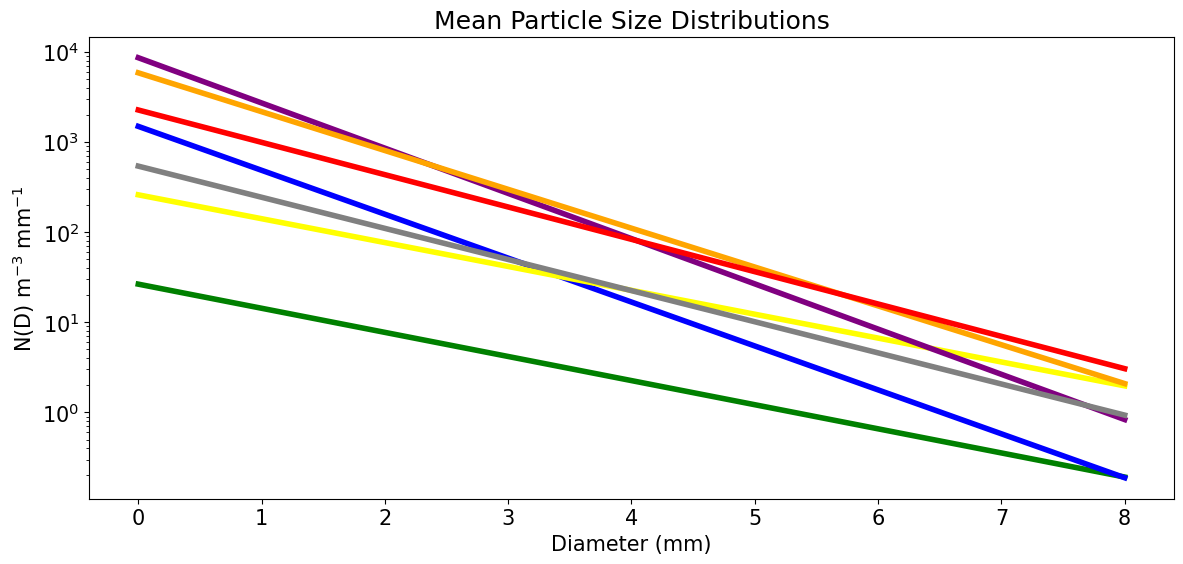

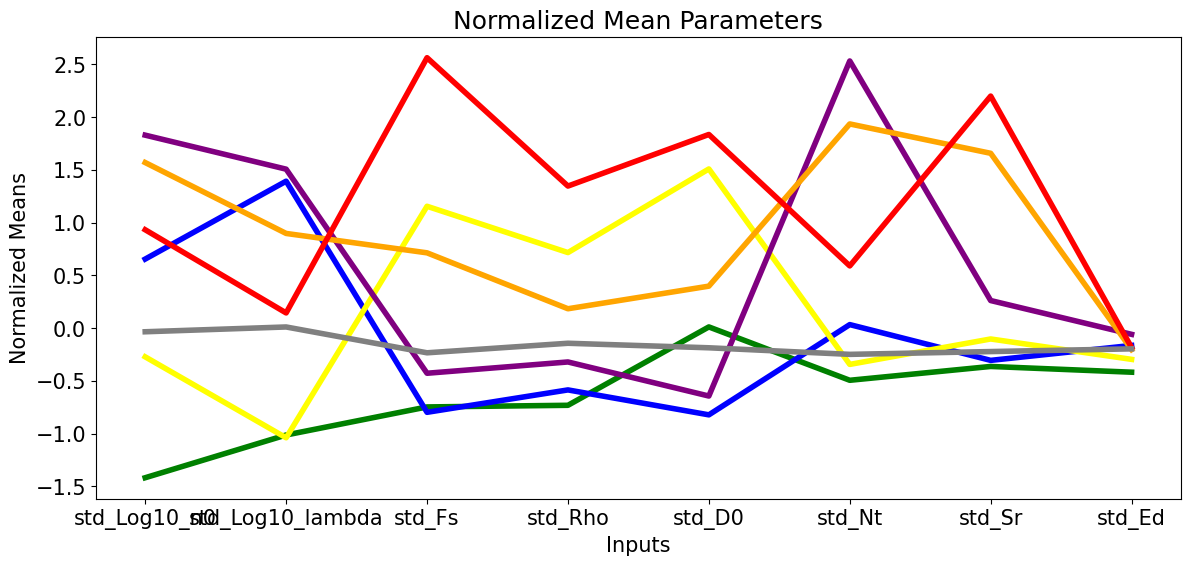

In [11]:

colors = ['green', 'blue', 'yellow', 'purple', 'orange', 'red', 'gray']
func = lambda t, a, b: a * np.exp(-b*t)
df_combo['n0'] = 10**df_combo['Log10_n0']
df_combo['lambda'] = 10**df_combo['Log10_lambda']

plt.figure(figsize=(14, 6))
plt.yscale('log')

for i in range(7):
    df_group = df_combo[df_combo['group'] == i+1]
    mean_n0 = df_group.loc[:, 'n0'].mean()
    mean_lambda = df_group.loc[:, 'lambda'].mean()

    t = np.linspace(0, 8, 500)
    y = func(t, mean_n0, mean_lambda)
    plt.plot(t, y, colors[i], linewidth=4)

plt.xlabel('Diameter (mm)')
plt.ylabel('N(D) m$^{-3}$ mm$^{-1}$')
plt.title('Mean Particle Size Distributions')
plt.show()


plt.figure(figsize=(14, 6))
for i in range(7):
    df_group = df_combo[df_combo['group'] == i+1]
    mean_n0 = df_group.loc[:, 'std_Log10_n0'].mean()
    mean_lambda = df_group.loc[:, 'std_Log10_lambda'].mean()
    mean_Nt = df_group.loc[:, 'std_Nt'].mean()
    mean_Fs = df_group.loc[:, 'std_Fs'].mean()
    mean_Rho = df_group.loc[:, 'std_Rho'].mean()
    mean_D0 = df_group.loc[:, 'std_D0'].mean()
    mean_Sr = df_group.loc[:, 'std_Sr'].mean()
    mean_Ed = df_group.loc[:, 'std_Ed'].mean()

    cols = ['std_Log10_n0', 'std_Log10_lambda', 'std_Fs', 'std_Rho', 'std_D0', 'std_Nt', 'std_Sr', 'std_Ed']
    plt.plot(cols, [mean_n0, mean_lambda, mean_Fs, mean_Rho, mean_D0, mean_Nt, mean_Sr, mean_Ed ], colors[i], linewidth=4)

plt.xlabel('Inputs')
plt.ylabel('Normalized Means')
plt.title('Normalized Mean Parameters')
plt.show()



In [45]:
new_df = pd.DataFrame(data={'eof1': principalDf.eof1, 'eof2': principalDf.eof2})
print(new_df)
clusterer = hdbscan.HDBSCAN(min_cluster_size=13)

cluster_labels = clusterer.fit_predict(new_df)

print(clusterer.labels_)
print(clusterer.labels_.max())
clusterer.probabilities_

df_combo['hdbscan_lab'] = clusterer.labels_
df_combo['hdbscan_prob'] = clusterer.probabilities_



           eof1      eof2
0     -1.960193 -0.202742
1     -1.983402 -0.033735
2     -1.559166 -0.300365
3     -1.247068 -0.334822
4     -1.447769 -0.735514
...         ...       ...
95077 -0.196611 -0.387003
95078 -0.089487 -0.657214
95079 -0.156413 -0.576724
95080 -0.158925 -0.683496
95081 -0.156160 -0.862509

[95082 rows x 2 columns]
[ -1  -1  -1 ...  -1 554  -1]
848


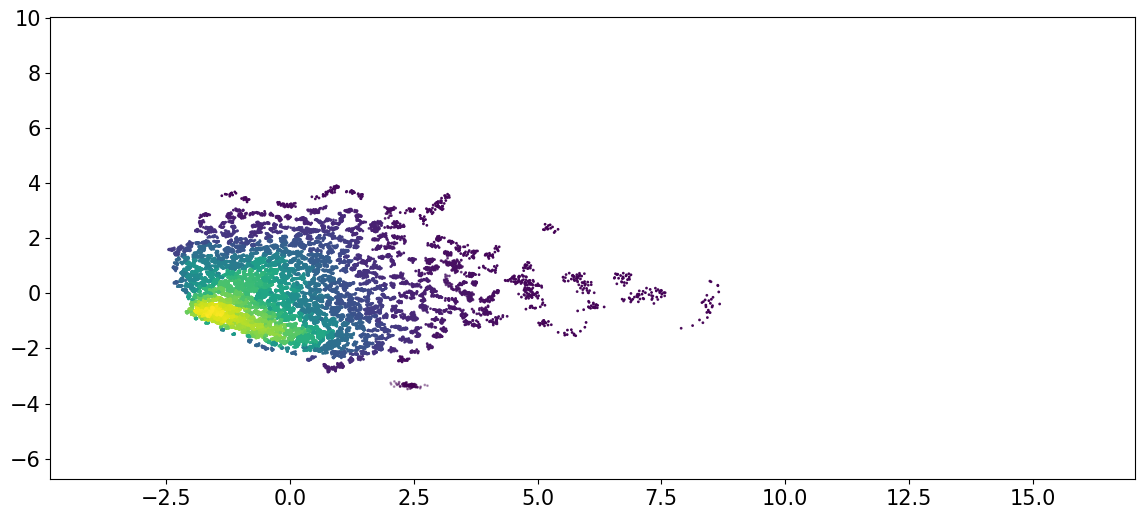

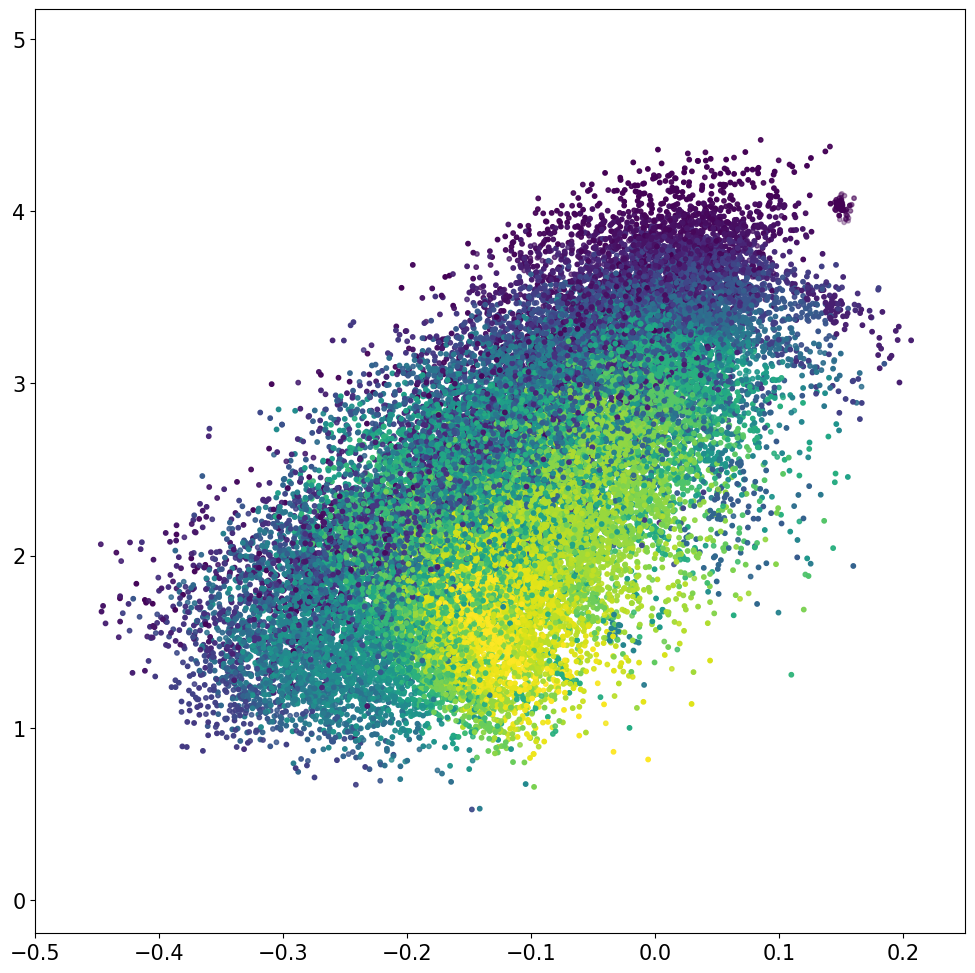

In [46]:
plt.figure(figsize=(14, 6))
plt.scatter(new_df.eof1, new_df.eof2, s=1, c=clusterer.labels_, alpha=clusterer.probabilities_)
plt.show()

color_dict = {1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple', 5: 'orange', 6: 'red', 7: 'gray'}

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
plt.scatter(df_combo['Log10_lambda'], df_combo['Log10_n0'], s=10, c=df_combo['hdbscan_lab'], alpha=df_combo['hdbscan_prob'])
# # sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="group")
# sns.scatterplot(data=df_combo, x="Log10_lambda", y="Log10_n0",  hue_order=[1, 2, 3, 4, 5, 6, 7], hue="group", palette=color_dict)
# sns.kdeplot(data=df_combo, x="Log10_lambda", y="Log10_n0", levels=2, hue="group",  hue_order=[1, 2, 3, 4, 5, 6, 7], palette=color_dict)

plt.show()